In [132]:
import pandas as pd
import json
import time
import matplotlib
import matplotlib.pyplot as plt
import re
import numpy as np
from nltk.tokenize import RegexpTokenizer
import nltk
# Import all the libraries required
import os
import pandas as pd
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import nltk
nltk.download('movie_reviews')
nltk.download('punkt')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Albert\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Albert\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#tweets_data = []
#
##with open('tweets_reduced_10000.jsons', 'r') as tweets_file:
#with open('geotagged_tweets_20160812-0912.jsons', 'r') as tweets_file:
##with open('customTweets.jsons', 'r') as tweets_file:
#    for line in tweets_file:
#        try:
#            tweet = json.loads(line)
#            tweets_data.append(tweet)
#        except Exception as e:
#            print (e)
#            continue

In [83]:
tweets_data = []

#with open('tweets_reduced_10000.jsons', 'r') as tweets_file:
#with open('geotagged_tweets_20160812-0912.jsons', 'r') as tweets_file:
#with open('customTweets.jsons', 'r') as tweets_file:
#with open('customTweetsWithSentiment.jsons', 'r') as tweets_file:
with open('customTweetsWithSentiment2.jsons', 'r') as tweets_file:
#with open('customTweetsWithSentimentWithNotEmptyCleanedText.jsons', 'r') as tweets_file:
    for line in tweets_file:
        try:
            tweet = json.loads(line)
            tweets_data.append(tweet)
        except Exception as e:
            print (e)
            continue

In [5]:
print(tweets_data[0]['sentiment'])

Negative


In [3]:
tweetsIdAndRetweetCount = []

#with open('tweets_reduced_10000.jsons', 'r') as tweets_file:
with open('geotagged_tweets_20160812-0912.jsons', 'r') as tweets_file:
#with open('customTweets.jsons', 'r') as tweets_file:
#with open('customTweetsWithSentiment.jsons', 'r') as tweets_file:
#with open('tweetsIdAndRetweetCount.jsons', 'r') as tweets_file:
    for line in tweets_file:
        try:
            tweet = json.loads(line)
            tweetsIdAndRetweetCount.append(tweet)
        except Exception as e:
            print (e)
            continue

In [183]:
 import json
 # with open('customTweetsWithSentiment2.jsons', 'w') as file:
with open('customTweetsWithSentiment3.jsons', 'w') as file:
    for i, tweet in enumerate(tweets_data):
        twt = {}
        twt['id'] = tweet['id']
        twt['in_reply_to_status_id'] = tweet['in_reply_to_status_id']
        twt['text'] =  tweet['text']
        twt['place'] =  tweet['place']
        twt['talk'] =  tweet['talk']
        twt['cleaned_text'] =  tweet['cleaned_text']
        if 'sentiment' in tweet:
            twt['sentiment'] =  tweet['sentiment'] 
        twt['sentiment_num'] =  tweet['sentiment_num']
        twt['talk_num'] =  tweet['talk_num']
        if 'replies' in tweet:
            twt['replies'] = tweet['replies']
        file.write(json.dumps(twt) + '\n')

In [84]:
def whoYouTalkAbout(tweetText):
    tweetText = tweetText.lower()
    keyWords = {
        'hillary' : ['hillary', 'clinton', 'imwithher'],
        'trump' : ['donald', 'trump']
    }
    talk = {
        'hillary': False,
        'trump': False
    }
    for candidate in talk.keys():
        for word in keyWords[candidate]:
            if word in tweetText:
                talk[candidate] = True
                break
        
    return talk

answer = whoYouTalkAbout('@theblaze @realDonaldTrump bla bla https:\/\/t.co\/TY9DlZ584c')
print(answer)
    
#
# probably talks about hillary:
# @HillaryClinton
# #hillaryclinton
# #hillary
# #crookedhillary
# #imwithher
# #neverhillary
# 
# probably talks about trump:
# @realDonaldTrump
# #donaldtrump
# #dumptrump
# #nevertrump
# #trump
# #trumppence16
# 
# neutral:
# #maga
#

{'hillary': False, 'trump': True}


In [85]:
mapIdToIdx = {}
for i, tweet in enumerate(tweets_data):
    mapIdToIdx[tweet['id']] = i
def getTweetThatThisIsAnsweringTo(tweetIdToFind, tweets):
    global mapIdToIdx
    idx = mapIdToIdx.get(tweetIdToFind,None)
    return None if idx == None else tweets[idx]

def evaluateTweet(idx, tweet):
    global justHillary
    global justTrump
    global both
    global neither
    global error
    global jt
    
    tweetText = tweet['text']
    if tweetText == "":
        error += 1
        return
    answer = whoYouTalkAbout(tweetText)
    
    if not answer['hillary'] and not answer['trump']:# if neither, check quoted_status['text']
        if 'quoted_status' in tweet and tweet['quoted_status']['text'] != None:
            tweetText = tweet['quoted_status']['text']
            answer = whoYouTalkAbout(tweetText)
        else:
            in_reply_to_status_id = tweet['in_reply_to_status_id']
            if in_reply_to_status_id != None:
                tweet = getTweetThatThisIsAnsweringTo(in_reply_to_status_id, tweets_data)
                if tweet != None:
                    evaluateTweet(idx,tweet)
                    return #ignore for now, next call to evaluateTweet should work
            neither += 1
            if neither < 5:
                print(tweets_data[idx]['id'], tweetText)
            tweets_data[idx]['talk'] = 'neither'
            return
    
    if answer['hillary'] and answer['trump']:
        both += 1
        tweets_data[idx]['talk'] = 'both'
    elif answer['hillary'] and not answer['trump']:
        justHillary += 1
        tweets_data[idx]['talk'] = 'hillary'
    elif not answer['hillary'] and answer['trump']:
        tweets_data[idx]['talk'] = 'trump'
        justTrump  += 1
        jt.append(idx)
    else:
        neither += 1
        tweets_data[idx]['talk'] = 'neither'
        if neither < 5:
            print(tweets_data[idx]['id'], tweetText)
        



In [86]:
justHillary = 0
justTrump = 0
both = 0
neither = 0
error = 0
jt = []

for i, tweet in enumerate(tweets_data):
    evaluateTweet(i, tweet)
            
print('\ntweets that talk about both: %d' % both)
print('tweets that talk about trump: %d' % justTrump)
print('tweets that talk about hillary: %d' % justHillary)
print('tweets that talk about neither: %d' % neither)
print('empty tweets: %d' % error)

print('tweets that talk about trump num: %d' % len(jt))

764040263132180480 Come to Jesus meeting!!!! What on earth is that supposed to be? 😔 https://t.co/a3lOpTtFig
764040676354908161 I don't hate Democrats. I hate the evil ideology of abortion and immigration they so proudly present as good America https://t.co/eR6GLDhj1M
764040797318582272 Hey,stop using the media.If they are so biased against you don't use,print or cable. https://t.co/TOtgdmW7wC
764040884086185984 Preach! https://t.co/0E1MDwU48r

tweets that talk about both: 100658
tweets that talk about trump: 354151
tweets that talk about hillary: 139297
tweets that talk about neither: 63201
empty tweets: 0
tweets that talk about trump num: 354151


In [65]:
t = 0

for i, tweet in enumerate(tweets_data):
    if tweet['talk'] == 'trump':
        t +=1
        
t

354151

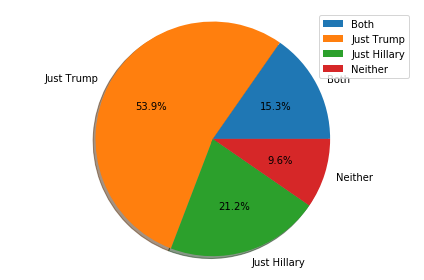

In [87]:
TOTAL = len(tweets_data)
 
labels = ['Both', 'Just Trump', 'Just Hillary', 'Neither']
sizes = [both/TOTAL, justTrump/TOTAL, justHillary/TOTAL, neither/TOTAL]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
pie = plt.pie(sizes, labels=labels, shadow=True, autopct='%1.1f%%')
plt.legend(pie[0], labels, loc="best")

plt.axis('equal')
plt.tight_layout()
plt.show()

# Cleaning

In [88]:
# A function that removes the hyperlinks from the tweet's content.
def remove_link(tweet):
    return re.sub(r"http\S+", "", tweet)

def remove_hashtags(tweet):
    return re.sub('#', '', tweet)

def remove_entire_hashtags(tweet):
    return re.sub(r'(?:\s|^)#[A-Za-z0-9\-\.\_]+(?:\s|$)', ' ', tweet).strip()

def remove_mentions(tweet):
    return " ".join(re.sub("(?:\@|https?\://)\S+"," ",tweet).split())


def remove_non_az_characters(tweet):
    return " ".join(re.sub('[^a-zA-Z]'," ",tweet).split())

In [89]:
# https://pypi.org/project/emoji/

import emoji

def extract_emojis(str):
    return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)

def text_without_emojis(str):
    return ''.join(c for c in str if c not in emoji.UNICODE_EMOJI)

text_with_emoji = "Come to Jesus meeting!!!! What on earth is that supposed to be? 😔 https://t.co/a3lOpTtFig"
print(text_with_emoji)
print(extract_emojis(text_with_emoji))
print(text_without_emojis(text_with_emoji))

Come to Jesus meeting!!!! What on earth is that supposed to be? 😔 https://t.co/a3lOpTtFig
😔
Come to Jesus meeting!!!! What on earth is that supposed to be?  https://t.co/a3lOpTtFig


In [157]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

# Create a set of stopwords
stop = set(stopwords.words('english'))

# Create a set of punctuation words 
exclude = set(string.punctuation) 

# This is the function makeing the lemmatization
lemma = WordNetLemmatizer()

# In this function we perform the entire cleaning
def clean(doc):
    doc = doc.lower()
    doc = remove_link(doc)
    #print('without links:', doc)
    doc = remove_mentions(doc)
    #print('without mentions:', doc)
    #doc = text_without_emojis(doc)
    #print('without emojis:', doc)
    doc = remove_entire_hashtags(doc)
    #doc = remove_hashtags(doc)
    #print('without hashtags:', doc)
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    #print('stop free:', doc)
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    #print('punc_free:', doc)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    #print('normalized:', normalized)
    normalized = remove_non_az_characters(normalized)
    #print('non-az removed:', normalized)
    normalized = " ".join(word for word in normalized.split() if len(word) > 3)
    return normalized

In [158]:
clean('@remy: This is @hello waaaaayyyy too much. For you!!!!!! #angry https://google.com 😔')

'waaaaayyyy much'

In [159]:
for i, tweet in enumerate(tweets_data):
    tweet['cleaned_text'] = clean(tweet['text'])
    tweets_data[i] = tweet

# Tokenizing

In [ ]:
# lower-casing
# removing all URLs & mentions & stop-words & tokens that consist only of non-alphanumeric characters (no emoticons) & short tokens (<3 characters)
# filter out all non-English
# remove very long conversations (>200 tweets) to avoid excessively long documents
# filter out all re-tweets (i.e., reposting tweets posted by other users) (they serve more as an endorsement rather than an original content)

In [92]:
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

In [93]:
s1 = '@remy: This is waaaaayyyy too much. For you!!!!!! #angry https://google.com'
tknzr.tokenize(s1)

[':',
 'This',
 'is',
 'waaayyy',
 'too',
 'much',
 '.',
 'For',
 'you',
 '!',
 '!',
 '!',
 '#angry',
 'https://google.com']

In [94]:
tknzr.tokenize('remy hello waaaaayyyy much you angry 😔')

['remy', 'hello', 'waaayyy', 'much', 'you', 'angry', '😔']

# Generating training set

In [80]:
dataframe = pd.read_csv("Sentiment.csv", sep=",", index_col='id')
dataframe.head()

,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
id,,,,,,,,,,,,,,,,,,,,
1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,I_Am_Kenzi,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,PeacefulQuest,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,PussssyCroook,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,MattFromTexas31,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,sharonDay5,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [19]:
dataframe = dataframe[['sentiment', 'text']]
dataframe.head()

,sentiment,text
id,,
1,Neutral,RT @NancyLeeGrahn: How did everyone feel about...
2,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...
3,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...
4,Positive,RT @RobGeorge: That Carly Fiorina is trending ...
5,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...


In [18]:
#dataframe2 = dataframe
#dataframe2['sentiment'].iloc[0] = np.array('bla')
#dataframe2['text'].iloc[0] = np.array('text bla')
#print(dataframe2.head())
#del dataframe2

In [95]:
training_set = []

for index, row in dataframe.iterrows():
    sentiment = row['sentiment']
    tweet_text = row['text']
    # cleaning
    cleaned_text = clean(tweet_text)
    # tokenizing
    tokenized_tweet = tknzr.tokenize(cleaned_text)
    
    training_set.append((tokenized_tweet, sentiment))
    

In [96]:
# Get the separate words in tweets
# Input:  A list of tweets
# Output: A list of all words in the tweets
def get_words_in_tweets(tweets):
    all_words = []
    for (words, sentiment) in tweets:
        all_words.extend(words)
    return all_words

# Create a dictionary measuring word frequencies
# Input: the list of words
# Output: the frequency of those words apearing in tweets
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    # print ("Word frequency list\n")
    # pprint(wordlist)
    return word_features


In [97]:
word_features = get_word_features(get_words_in_tweets(training_set))

# Construct our features based on which tweets contain which word
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features[word] = (word in document_words)
    return features

In [98]:
# Here we apply the features we constructed to our tweets data.
training_set = nltk.classify.apply_features(extract_features, training_set)

In [23]:
# Printing the resulting training set shows the features we are going to pass to the classifier.
# pprint(training_set)

In [99]:
# This is the line of code that we use to train our classifier. Training is performed in a streamlined way so no output is visible.
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [100]:
print (classifier.show_most_informative_features(32))

Most Informative Features
          donniewahlberg = True           Positi : Negati =     87.3 : 1.0
              imwithhuck = True           Positi : Negati =     69.6 : 1.0
               lrihendry = True           Positi : Negati =     63.7 : 1.0
                libertyu = True           Positi : Negati =     46.8 : 1.0
             wilberforce = True           Positi : Negati =     44.3 : 1.0
            kimguilfoyle = True           Positi : Negati =     36.7 : 1.0
                 forward = True           Positi : Negati =     35.2 : 1.0
                    imho = True           Positi : Negati =     31.6 : 1.0
            monaeltahawy = True           Negati : Positi =     29.1 : 1.0
               obviously = True           Negati : Positi =     28.0 : 1.0
              transcript = True           Neutra : Negati =     27.9 : 1.0
               influence = True           Negati : Positi =     27.5 : 1.0
                  makeup = True           Negati : Positi =     26.2 : 1.0

In [101]:
# The tweet we are about to classify
tweet = 'This dish is horrible'
print (classifier.classify(extract_features(tweet.split())))

Negative


In [187]:
sent          = TextBlob("This dish is horrible", analyzer = NaiveBayesAnalyzer())
print(sent.sentiment.classification)
sent.sentiment

neg


Sentiment(classification='neg', p_pos=0.35008478632074624, p_neg=0.6499152136792535)

In [102]:
tweet = 'Ivo listens to horrendous electronic music'
print (classifier.classify(extract_features(tweet.split())))

Negative


In [186]:
sent          = TextBlob("Ivo listens to horrendous electronic music", analyzer = NaiveBayesAnalyzer())
print(sent.sentiment.classification)
sent.sentiment

neg


Sentiment(classification='neg', p_pos=0.4883445582310797, p_neg=0.5116554417689199)

In [103]:
tweet = "Come to Jesus meeting!!!! What on earth is that supposed to be? 😔"
print (classifier.classify(extract_features(tweet.split())))

Negative


In [185]:
sent          = TextBlob("Come to Jesus meeting!!!! What on earth is that supposed to be? 😔", analyzer = NaiveBayesAnalyzer())
print(sent.sentiment.classification)
sent.sentiment

pos


Sentiment(classification='pos', p_pos=0.5917171731855415, p_neg=0.4082828268144588)

In [104]:
tweet = "I'm so happy today"
print (classifier.classify(extract_features(tweet.split())))

Negative


In [184]:
sent          = TextBlob("I'm so happy today", analyzer = NaiveBayesAnalyzer())
print(sent.sentiment.classification)
sent.sentiment

pos


Sentiment(classification='pos', p_pos=0.7367024460316827, p_neg=0.2632975539683174)

In [188]:
sent          = TextBlob("I like math", analyzer = NaiveBayesAnalyzer())
print(sent.sentiment.classification)
sent.sentiment

pos


Sentiment(classification='pos', p_pos=0.5608742774566471, p_neg=0.4391257225433527)

The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [108]:
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
print(testimonial.sentiment.subjectivity)
print(testimonial.sentiment.polarity)

0.4357142857142857
0.39166666666666666


negatiu [-1.0, -0.1]
neutral [-0.1, +0.1]
positiu [+0.1, +1.0]

In [144]:
analyzerNaiveBayes = NaiveBayesAnalyzer()

def getSentimentValue(txt):
    global analyzerNaiveBayes
    
    sent = TextBlob(txt, analyzer = analyzerNaiveBayes)
    val = sent.sentiment.classification
    if val == 'neg':
        return 'Negative'
    if val == 'pos':
        return 'Positive'
    return 'Neutral'

In [160]:
positive = 0
negative = 0
neutral = 0

for i, tweet in enumerate(tweets_data):
    text = tweet['cleaned_text']
    sentimentText = getSentimentValue(text)
    if sentimentText == 'Negative':
        negative += 1
    elif sentimentText == 'Positive':
        positive += 1
    else:
        neutral += 1

print('Number of tweets positive: ', positive)
print('Number of tweets neutral: ', neutral)
print('Number of tweets negative: ', negative)

Number of tweets positive:  426130
Number of tweets neutral:  0
Number of tweets negative:  231177


In [134]:
sent          = TextBlob("@realDonaldTrump is such an asshole!! https://t.co/TAinjWbfZh", analyzer = NaiveBayesAnalyzer())
print(sent.sentiment.classification)
sent.sentiment

neg


Sentiment(classification='neg', p_pos=0.325051595491348, p_neg=0.674948404508652)

In [138]:
sent          = TextBlob("Hey, check out our new Video!", analyzer = NaiveBayesAnalyzer())
print(sent.sentiment.classification)
sent.sentiment

neg


Sentiment(classification='neg', p_pos=0.2200817281023955, p_neg=0.7799182718976042)

In [137]:
sent          = TextBlob(clean("Hey, check out our new Video!"), analyzer = NaiveBayesAnalyzer())
print(sent.sentiment.classification)
sent.sentiment

neg


Sentiment(classification='neg', p_pos=0.3048559624200577, p_neg=0.695144037579942)

In [141]:
sent          = TextBlob("Hey, check out our new Video!")
sent.sentiment

Sentiment(polarity=0.17045454545454544, subjectivity=0.45454545454545453)

In [142]:
sent          = TextBlob(clean("Hey, check out our new Video!"))
sent.sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

## Are our tweets positive, negative or neutral?

In [146]:
NUM_TWEETS = len(tweets_data) # len(tweets_data)

In [161]:
for i, tweet in enumerate(tweets_data[:NUM_TWEETS]):
    if i % 10000 == 0:
        print(i)
    cleanedText = tweet['cleaned_text']
    tweet['sentiment'] = getSentimentValue(cleanedText)#classifier.classify(extract_features(cleanedText.split()))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000


In [48]:
found = False
for i, tweet in enumerate(tweets_data[:NUM_TWEETS]):
    if 'sentiment' not in tweet:
        print(i)
        found = True
        break
print(found)

False


In [85]:
tweets_data = [tweet for tweet in tweets_data if tweet['cleaned_text'] != ""]

In [86]:
len(tweets_data)

607531

# Positivity - Negativity - Neutrality per state

In [162]:
positivesTweets = 0
neutralTweets = 0
negativesTweets = 0

for i, tweet in enumerate(tweets_data[:NUM_TWEETS]):
    sentiment = tweet['sentiment']
    
    if sentiment == 'Positive':
        positivesTweets += 1
        s = 1
    elif sentiment == 'Negative':
        negativesTweets += 1
        s = -1
    else:  # neutral
        neutralTweets += 1
        s = 0
    tweets_data[i]['sentiment_num'] = s
print(positivesTweets, negativesTweets, neutralTweets)

mapStateToSentiment = {}
for tweet in tweets_data[:NUM_TWEETS]:
    if tweet['place'] == None:
        continue
    countryCode = tweet['place']['country_code']

    city = tweet['place']['full_name']
    if countryCode != 'US' or ',' not in city:
        continue
    cityAndState = city.split(',')
    state = cityAndState[1].strip()
    if len(state) != 2: # skip Philadelphia
        continue
    tweet['place']['state_name'] = state
    s = tweet['sentiment_num']
    if state not in mapStateToSentiment:
        mapStateToSentiment[state] = 0
    mapStateToSentiment[state] += s
    
values = mapStateToSentiment.values()
min_sentiment = min(values)
max_sentiment = max(values)

426130 231177 0


In [163]:
len(mapStateToSentiment.keys())

52

In [164]:
mapStateToSentiment

{'MO': 2065,
 'LA': 1266,
 'MD': 2065,
 'CA': 19248,
 'NJ': 3974,
 'TX': 11423,
 'MI': 2060,
 'KY': 805,
 'IA': 999,
 'FL': 11771,
 'MA': 3023,
 'PA': 3900,
 'VA': 2354,
 'AZ': 3904,
 'NY': 11143,
 'UT': 574,
 'OR': 1467,
 'CT': 1027,
 'SC': 1224,
 'DE': 88,
 'OK': 764,
 'IL': 5940,
 'TN': 2497,
 'KS': 642,
 'MS': 734,
 'NC': 2876,
 'GA': 2562,
 'OH': 3115,
 'MN': 1120,
 'WI': 1350,
 'ME': 565,
 'CO': 1578,
 'AR': 438,
 'WA': 2800,
 'RI': 504,
 'NV': 2063,
 'DC': 1531,
 'NE': 296,
 'WV': 252,
 'IN': 1294,
 'HI': 852,
 'ID': 414,
 'AL': 2401,
 'NM': 725,
 'NH': 946,
 'VT': 70,
 'ND': 27,
 'MT': 90,
 'SD': 105,
 'AK': 202,
 'WY': 42,
 'Mo': -1}

In [165]:
S_DIR = 'states_21basic/' 
BLUE = '#5599ff'

with open(os.path.join(S_DIR, 'states.json')) as rf:    
    data = json.load(rf)

def displayUSMap(mapp, cmap = plt.cm.inferno):
    fig = plt.figure(figsize=(20,10))
    ax = fig.gca()
    for feature in data['features']:
        geometry = feature['geometry']
        props = feature['properties']
        NAME = props['STATE_ABBR']
        POP = mapp.get(NAME,0)
        norm = matplotlib.colors.Normalize(vmin=min_sentiment, vmax=max_sentiment)
        col = cmap(norm(POP))
        #print(NAME,POP,col)
        if geometry['type'] == 'Polygon':
            poly = geometry
            ppatch = PolygonPatch(poly, fc=col, ec=col,  alpha=0.5, zorder=2)
            ax.add_patch(ppatch)
        elif geometry['type'] == 'MultiPolygon':
            for polygon in geometry['coordinates'][0]:
                poly = Polygon(polygon)
                ppatch = PolygonPatch(poly, fc=col, ec=col, alpha=0.5, zorder=2)
                ax.add_patch(ppatch)
        else:
            print('Don\'t know how to draw :', geometry['type'])

    ax.axis('scaled')
    plt.axis('off')
    plt.show()

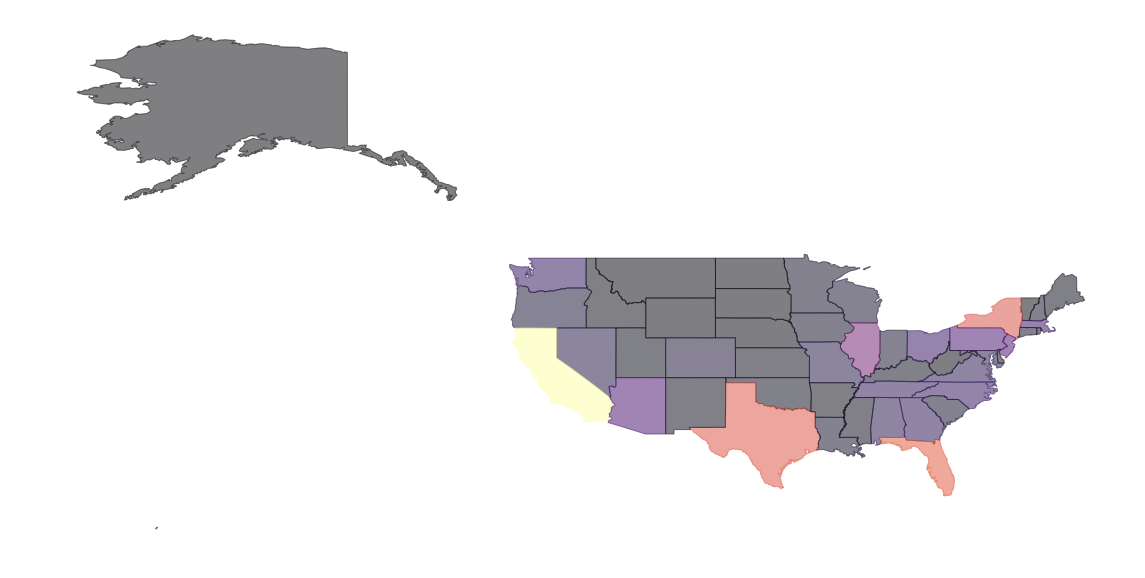

In [166]:
displayUSMap(mapStateToSentiment, plt.cm.inferno)

# Hillary vs Trump?

In [167]:
for i, tweet in enumerate(tweets_data[:NUM_TWEETS]):
    talk = tweet['talk']
    if talk == 'hillary':
        s = 1
    elif talk == 'trump':
        s = -1
    elif talk == 'both':
        s = 0
    else:  # neutral
        s = None
    tweets_data[i]['talk_num'] = s

mapStateToTalk = {}
for tweet in tweets_data[:NUM_TWEETS]:
    if tweet['place'] == None:
        continue
    countryCode = tweet['place']['country_code']
    city = tweet['place']['full_name']
    if countryCode != 'US' or ',' not in city:
        continue
    cityAndState = city.split(',')
    state = cityAndState[1].strip()
    if len(state) != 2: # skip Philadelphia
        continue
    tweet['place']['state_name'] = state
    s = tweet['talk_num']
    #print(s)
    if s == None:
        continue
    if state not in mapStateToTalk:
        mapStateToTalk[state] = 0
    
    mapStateToTalk[state] += s


values = mapStateToTalk.values()

min_talk = min(values)
max_talk = max(values)

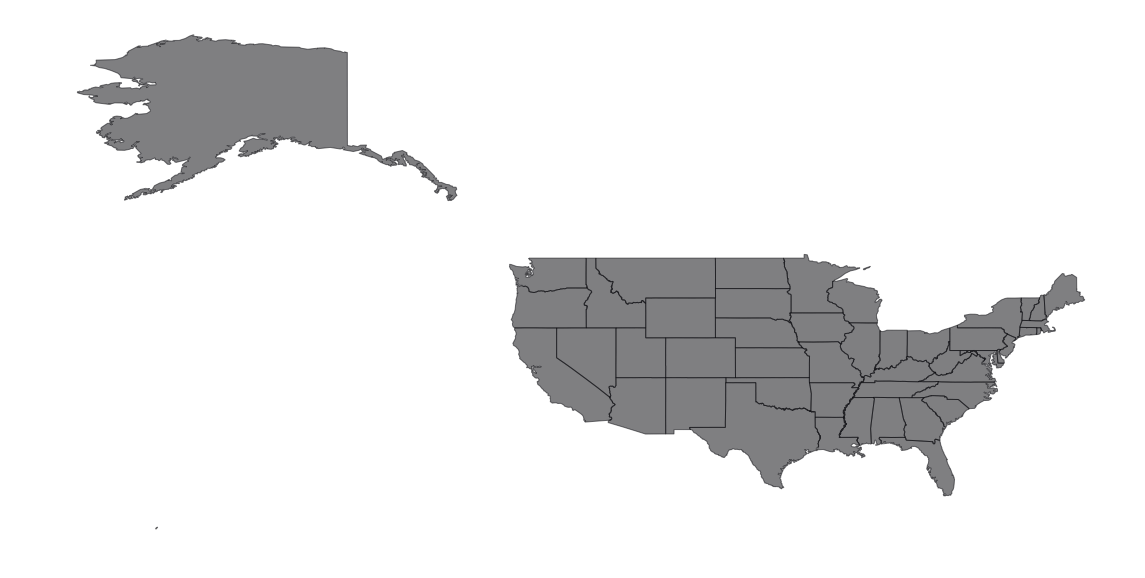

In [181]:
displayUSMap(mapStateToTalk)

In [180]:
print(min_talk, max_talk)

-21766 -1


In [170]:
mapStateToTalk

{'MO': -1741,
 'LA': -1680,
 'MD': -4188,
 'CA': -21766,
 'NJ': -4609,
 'TX': -12196,
 'MI': -2854,
 'KY': -1107,
 'IA': -630,
 'FL': -12823,
 'MA': -3863,
 'VA': -1852,
 'AZ': -5527,
 'NY': -14978,
 'UT': -706,
 'OR': -2636,
 'CT': -1244,
 'PA': -4566,
 'SC': -903,
 'DE': -126,
 'OK': -786,
 'IL': -6191,
 'TN': -2722,
 'KS': -972,
 'NC': -2888,
 'GA': -2625,
 'OH': -3334,
 'MN': -1083,
 'WI': -1443,
 'ME': -465,
 'MS': -398,
 'AR': -313,
 'WA': -3777,
 'RI': -484,
 'NV': -1889,
 'DC': -1469,
 'CO': -578,
 'NE': -738,
 'WV': -628,
 'IN': -1371,
 'HI': -1046,
 'ID': -526,
 'AL': -3209,
 'NM': -932,
 'NH': -646,
 'VT': -63,
 'ND': -84,
 'MT': -81,
 'SD': -123,
 'AK': -331,
 'WY': -66,
 'Mo': -1}

In [46]:
# import json
# 
# with open('customTweetsWithSentiment.jsons', 'w') as file:
#     for i, tweet in enumerate(tweets_data):
#         file.write(json.dumps(tweet) + '\n')

# Which kind of tweets are replied the most? (Albert) Are neutral tweet more or less likely to be replied than positive and negative tweets?

In [1]:
# tweet1 - positive = 2
# 	tweet2 - negative = 0
# 	tweet3 - negative = 1
# 		tweet4 - neutral = 1
# 			tweet6 - positive = 0
# 
# tweet5 - negative = 0

In [14]:
tweets_test = [
    {
        'id': 1,
        'in_reply_to_status_id': -1,
        'sentiment':'Positive'
    },
    {
        'id': 2,
        'in_reply_to_status_id': 1,
        'sentiment':'Negative'
    },
    {
        'id': 3,
        'in_reply_to_status_id': 1,
        'sentiment':'Negative'
    },
    {
        'id': 4,
        'in_reply_to_status_id': 3,
        'sentiment':'Neutral'
    },
    {
        'id': 6,
        'in_reply_to_status_id': 4,
        'sentiment':'Neutral'
    },
    {
        'id': 5,
        'in_reply_to_status_id': -1,
        'sentiment':'Negative'
    },
]

In [171]:
mapSentimentToRepliesCount = {'Positive': 0, 'Negative': 0, 'Neutral': 0}

def f(tweet, tweets, isParent):
    id = tweet['id']
    in_reply_to_status_id = tweet['in_reply_to_status_id']
    sentiment = tweet['sentiment']
    
    parentTweet = getTweetThatThisIsAnsweringTo(in_reply_to_status_id, tweets)
    if not(parentTweet == None or isParent == True): # parent found
        f(parentTweet, tweets, True)
    elif isParent == True:
        mapSentimentToRepliesCount[sentiment] += 1
        if 'replies' in tweet:
            tweet['replies'] += 1
        else:
            tweet['replies'] = 1



In [172]:
num = len(tweets_data)

for i, tweet in enumerate(tweets_data[:num]):
    f(tweet, tweets_data[:num], False)
    if i%50000==0:
        print(i)
    
    
mapSentimentToRepliesCount

0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000


{'Positive': 13007, 'Negative': 6356, 'Neutral': 0}

In [60]:
i

202073

In [11]:
for i, tweet in enumerate(tweets_data[:num]):
    if 'replies' not in tweet:
        print(i)
        break

0


In [76]:
764042476487217152 in mapIdToIdx

False

In [78]:
mapIdToIdx.get(764042476487417152,0)

0

In [79]:
mapIdToIdx.get(764042476487217152,0)

55

In [173]:
tweets_without_reply = num - sum(mapSentimentToRepliesCount.values())
tweets_without_reply

637944

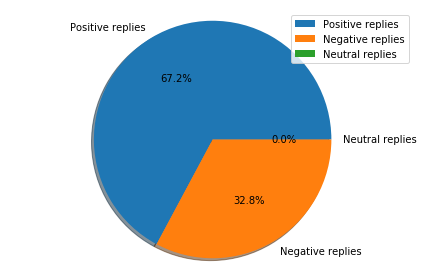

In [174]:
TOTAL = sum(mapSentimentToRepliesCount.values())
 
labels = ['Positive replies', 'Negative replies', 'Neutral replies']
sizes = [mapSentimentToRepliesCount['Positive']/TOTAL, mapSentimentToRepliesCount['Negative']/TOTAL, mapSentimentToRepliesCount['Neutral']/TOTAL]
pie = plt.pie(sizes, labels=labels, shadow=True, autopct='%1.1f%%')
plt.legend(pie[0], labels, loc="best")

plt.axis('equal')
plt.tight_layout()
plt.show()

In [175]:
sumEmptyTweets = 0
for i, tweet in enumerate(tweets_data):
    if tweet['cleaned_text'] == "":
        sumEmptyTweets += 1
sumEmptyTweets

61580

In [176]:
mapSentimentToRepliesCount

{'Positive': 13007, 'Negative': 6356, 'Neutral': 0}

## POSITIVE TRUMP  + NEGATIVE HILARY vs NEGATIVE TRUMP + POSITIVE HILLARY

## pro Trump vs pro hillary

In [177]:
mapSentimentToCandidate = {'trump': {'Positive':0, 'Negative':0, 'Neutral':0}, 'hillary':{'Positive':0, 'Negative':0, 'Neutral':0}}

cleaned = 0
bothNeither = 0
trump = 0

for i, tweet in enumerate(tweets_data):
    candidate = tweet['talk']
    sentiment = tweet['sentiment']
    
    if candidate == 'trump':
        trump += 1
        
    if candidate not in mapSentimentToCandidate:
        bothNeither += 1
        continue
        
    if tweet['cleaned_text'] == "":
        cleaned += 1
    
    mapSentimentToCandidate[candidate][sentiment] += 1
    
print('cleaned:', cleaned)
print('bothNeither:', bothNeither)
print('trump:', trump)
mapSentimentToCandidate

cleaned: 48072
bothNeither: 163859
trump: 354151


{'trump': {'Positive': 233547, 'Negative': 120604, 'Neutral': 0},
 'hillary': {'Positive': 91624, 'Negative': 47673, 'Neutral': 0}}

In [16]:
len(tweets_data)

657307

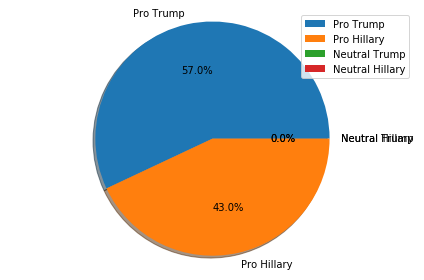

In [178]:
TOTAL = sum(mapSentimentToCandidate['trump'].values())+sum(mapSentimentToCandidate['hillary'].values())
 
labels = ['Pro Trump', 'Pro Hillary', 'Neutral Trump', 'Neutral Hillary']
sizes = [
    (mapSentimentToCandidate['trump']['Positive']+mapSentimentToCandidate['hillary']['Negative'])/TOTAL, 
         (mapSentimentToCandidate['hillary']['Positive']+mapSentimentToCandidate['trump']['Negative'])/TOTAL,
    mapSentimentToCandidate['trump']['Neutral']/TOTAL, 
    mapSentimentToCandidate['hillary']['Neutral']/TOTAL
        ]
pie = plt.pie(sizes, labels=labels, shadow=True, autopct='%1.1f%%')
plt.legend(pie[0], labels, loc="best")

plt.axis('equal')
plt.tight_layout()
plt.show()

In [189]:
# pro trump = -1
# pro hillary = +1
mapStateToProTrumpProHillary = {}
for tweet in tweets_data:
    if tweet['place'] == None:
        continue
    countryCode = tweet['place']['country_code']
    city = tweet['place']['full_name']
    if countryCode != 'US' or ',' not in city:
        continue
    cityAndState = city.split(',')
    state = cityAndState[1].strip()
    if len(state) != 2: # skip Philadelphia
        continue
    tweet['place']['state_name'] = state
    
    #print(s)
    if s == None:
        continue
    if state not in mapStateToProTrumpProHillary:
        mapStateToProTrumpProHillary[state] = 0
    
    talk = tweet['talk']
    sentiment = tweet['sentiment']
    if (talk == 'trump' and sentiment == 'Positive') or (talk == 'hillary' and sentiment == 'Negative'):
        val = -1
    else:
        val = 1
    mapStateToProTrumpProHillary[state] += val

mapStateToProTrumpProHillary

{'MO': 785,
 'LA': 548,
 'MD': 1133,
 'CA': 11138,
 'NJ': 2934,
 'TX': 3433,
 'MI': 1266,
 'KY': 389,
 'IA': 1509,
 'FL': 5983,
 'MA': 1931,
 'PA': 2104,
 'VA': 2072,
 'AZ': 2174,
 'NY': 6761,
 'UT': 372,
 'OR': 1227,
 'CT': 655,
 'SC': 868,
 'DE': 116,
 'OK': 702,
 'IL': 2724,
 'TN': 913,
 'KS': 246,
 'MS': 516,
 'NC': 1616,
 'GA': 1516,
 'OH': 2363,
 'MN': 822,
 'WI': 1020,
 'ME': 201,
 'CO': 1932,
 'AR': 182,
 'WA': 1466,
 'RI': 362,
 'NV': 1353,
 'DC': 633,
 'NE': 272,
 'WV': 36,
 'IN': 780,
 'HI': 226,
 'ID': 118,
 'AL': -285,
 'NM': 305,
 'NH': 414,
 'VT': 24,
 'ND': 69,
 'MT': 78,
 'SD': 15,
 'AK': 242,
 'WY': 44,
 'Mo': 1}

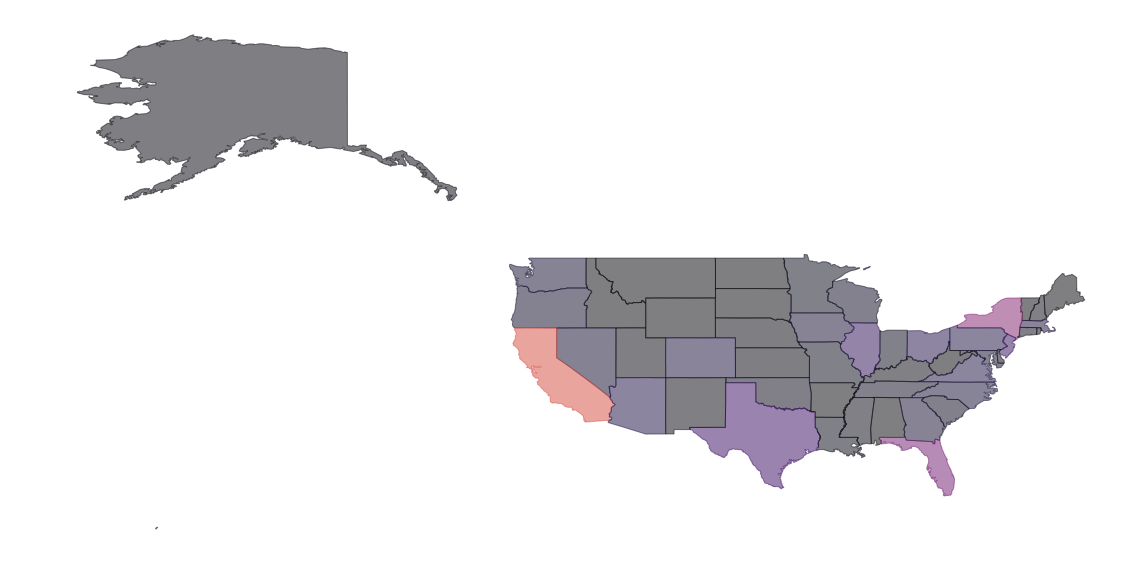

In [190]:
displayUSMap(mapStateToProTrumpProHillary)

## Proportional to number of tweets per state

In [238]:
mapStateToNumberOfTweets = {}
mapStateToNumberOfTweetsTrumpOnly = {}
mapStateToNumberOfTweetsHillaryOnly = {}

for tweet in tweets_data:
    if tweet['place'] == None:
        continue
    countryCode = tweet['place']['country_code']
    city = tweet['place']['full_name']
    candidate = tweet['talk']
    if countryCode != 'US' or ',' not in city:
        continue
    cityAndState = city.split(',')
    state = cityAndState[1].strip()
    if len(state) != 2: # skip Philadelphia
        continue
    if state not in mapStateToNumberOfTweets:
        mapStateToNumberOfTweets[state] = 0
    if candidate == 'trump' and state not in mapStateToNumberOfTweetsTrumpOnly:
        mapStateToNumberOfTweetsTrumpOnly[state] = 0
    if candidate == 'hillary' and state not in mapStateToNumberOfTweetsHillaryOnly:
        mapStateToNumberOfTweetsHillaryOnly[state] = 0 

    if candidate == 'trump':
        mapStateToNumberOfTweetsTrumpOnly[state] += 1
    if candidate == 'hillary':
        mapStateToNumberOfTweetsHillaryOnly[state] += 1
    mapStateToNumberOfTweets[state] += 1
    
print('mapStateToNumberOfTweets', mapStateToNumberOfTweets)
print('mapStateToNumberOfTweetsTrumpOnly', mapStateToNumberOfTweetsTrumpOnly)
print('mapStateToNumberOfTweetsHillaryOnly', mapStateToNumberOfTweetsHillaryOnly)
    

mapStateToNumberOfTweets {'MO': 6303, 'LA': 4706, 'MD': 8999, 'CA': 67370, 'NJ': 15852, 'TX': 34437, 'MI': 8810, 'KY': 3081, 'IA': 3481, 'FL': 40241, 'MA': 11733, 'PA': 13804, 'VA': 9806, 'AZ': 14686, 'NY': 42179, 'UT': 2288, 'OR': 7045, 'CT': 3989, 'SC': 3992, 'DE': 482, 'OK': 3356, 'IL': 19672, 'TN': 7825, 'KS': 2358, 'MS': 2334, 'NC': 9832, 'GA': 8984, 'OH': 12235, 'MN': 3798, 'WI': 4414, 'ME': 1805, 'CO': 6520, 'AR': 1518, 'WA': 10764, 'RI': 2060, 'NV': 7155, 'DC': 4415, 'NE': 1594, 'WV': 1070, 'IN': 4822, 'HI': 2540, 'ID': 1402, 'AL': 6171, 'NM': 2601, 'NH': 2484, 'VT': 298, 'ND': 287, 'MT': 392, 'SD': 323, 'AK': 1030, 'WY': 358, 'Mo': 1}
mapStateToNumberOfTweetsTrumpOnly {'MO': 3225, 'LA': 2472, 'MD': 5586, 'CA': 36046, 'NJ': 8326, 'MI': 4809, 'IA': 1184, 'VA': 4567, 'AZ': 8103, 'NY': 23235, 'UT': 1223, 'TX': 19039, 'SC': 1848, 'DE': 239, 'FL': 21330, 'MA': 6371, 'GA': 4639, 'PA': 7436, 'OH': 6278, 'NC': 5090, 'MN': 1940, 'WI': 2147, 'MS': 1069, 'AR': 730, 'CT': 2141, 'IL': 10597

In [218]:
mapStateToProTrumpProHillaryProportional = mapStateToProTrumpProHillary.copy()
factor = 100000
for state in mapStateToNumberOfTweets.keys():
    mapStateToProTrumpProHillaryProportional[state] =factor* mapStateToProTrumpProHillary[state]/mapStateToNumberOfTweets[state]
    
mapStateToProTrumpProHillaryProportional

{'MO': 12454.386799936537,
 'LA': 11644.708882277942,
 'MD': 12590.287809756639,
 'CA': 16532.58126762654,
 'NJ': 18508.705526116577,
 'TX': 9968.928768475767,
 'MI': 14370.034052213394,
 'KY': 12625.770853618955,
 'IA': 43349.61218040793,
 'FL': 14867.920777316667,
 'MA': 16457.85391630444,
 'PA': 15241.95885250652,
 'VA': 21129.920456863147,
 'AZ': 14803.213945253983,
 'NY': 16029.303681927026,
 'UT': 16258.741258741258,
 'OR': 17416.607523066003,
 'CT': 16420.15542742542,
 'SC': 21743.486973947896,
 'DE': 24066.390041493774,
 'OK': 20917.75923718713,
 'IL': 13847.09231394876,
 'TN': 11667.73162939297,
 'KS': 10432.569974554708,
 'MS': 22107.96915167095,
 'NC': 16436.12693246542,
 'GA': 16874.443455031167,
 'OH': 19313.44503473641,
 'MN': 21642.969984202213,
 'WI': 23108.29179882193,
 'ME': 11135.73407202216,
 'CO': 29631.9018404908,
 'AR': 11989.459815546772,
 'WA': 13619.472315124489,
 'RI': 17572.81553398058,
 'NV': 18909.85324947589,
 'DC': 14337.485843714609,
 'NE': 17063.989962

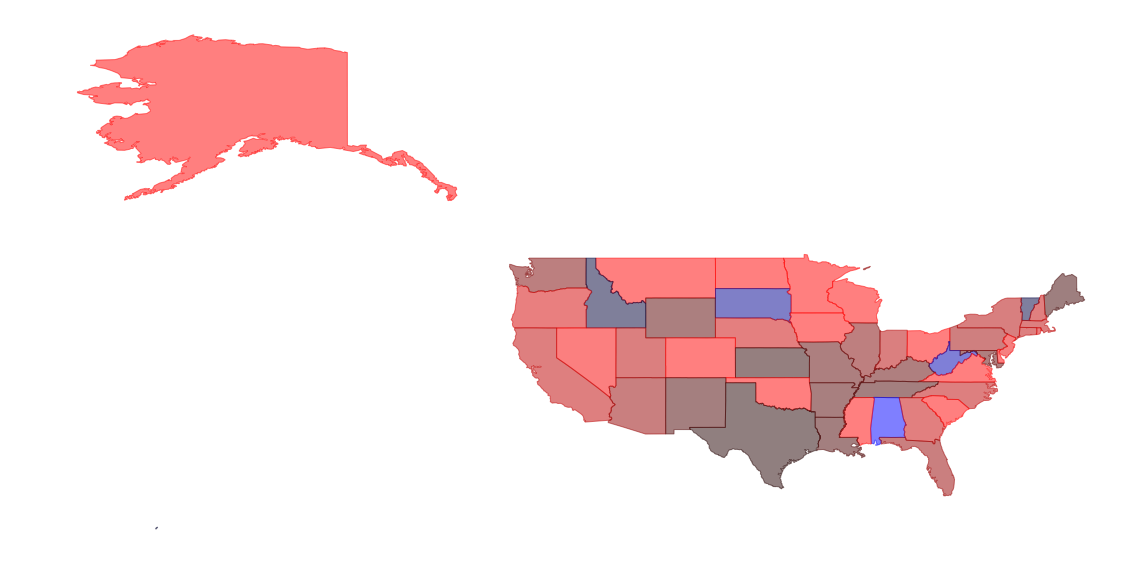

In [222]:
from matplotlib.colors import LinearSegmentedColormap
cdict1 = {

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.1, 0.0),
                   (1.0, 0.0, 0.0)),
    
        'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.1),
                   (1.0, 1.0, 1.0))
        }
RedBlue = LinearSegmentedColormap('RedBlue', cdict1)
displayUSMap(mapStateToProTrumpProHillaryProportional, RedBlue)

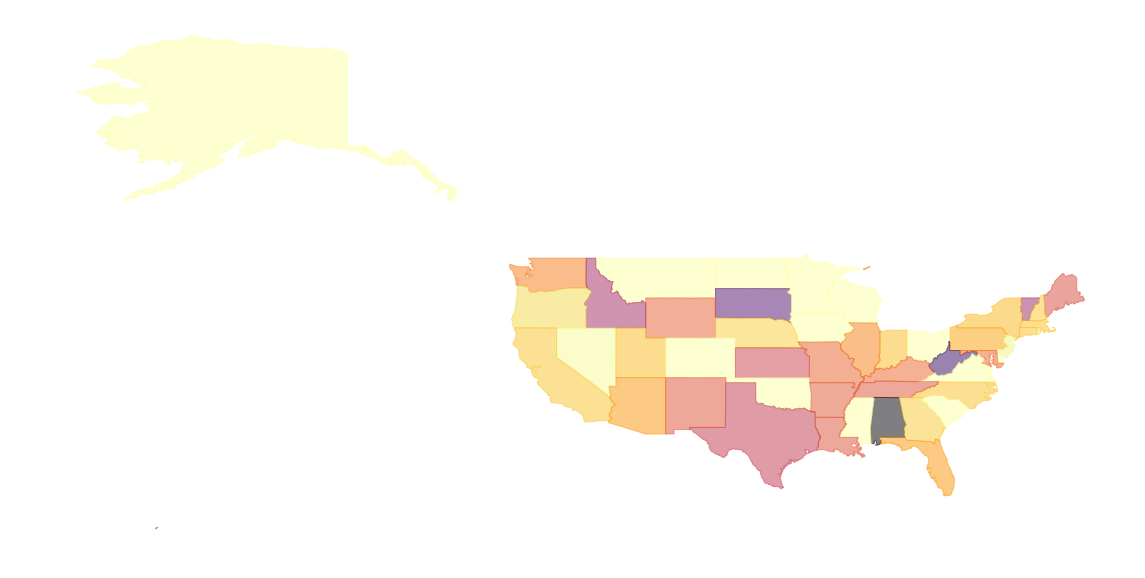

In [204]:
displayUSMap(mapStateToProTrumpProHillaryProportional)

## plotly

In [236]:
import plotly.plotly as py
from plotly.offline import iplot,init_notebook_mode
init_notebook_mode(connected=True)

scl = [[0.0, 'rgb(255,0,0)'],[0.5, 'rgb(255,255,255)'],\
            [1.0, 'rgb(0,0,255)']]

# df['text'] = df['state'] + '<br>' +\
#     'Beef '+df['beef']+' Dairy '+df['dairy']+'<br>'+\
#     'Fruits '+df['total fruits']+' Veggies ' + df['total veggies']+'<br>'+\
#     'Wheat '+df['wheat']+' Corn '+df['corn']

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = list(mapStateToProTrumpProHillary.keys()),
        z = list(mapStateToProTrumpProHillary.values()),
        locationmode = 'USA-states',
        text = 'Result',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "More positive means more prohillary")
        ) ]

layout = dict(
        title = 'Pro Hillary vs Pro Trump',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )

## Ratio pos/neg Trump vs pos/neg Hillary

In [267]:
mapStateToSentimentTrump = {}
mapStateToSentimentHillary = {}

# si num de tweets de trump o hillary son menors q X en un estat
# ignorem aquell estat

for tweet in tweets_data:
    if tweet['place'] == None:
        continue
    countryCode = tweet['place']['country_code']
    city = tweet['place']['full_name']
    if countryCode != 'US' or ',' not in city:
        continue
    cityAndState = city.split(',')
    state = cityAndState[1].strip()
    if len(state) != 2: # skip Philadelphia
        continue
    candidate = tweet['talk']
    sentiment = tweet['sentiment']
    if candidate != 'trump' and candidate != 'hillary':
        continue
    if candidate == 'trump' and state not in mapStateToSentimentTrump:
        mapStateToSentimentTrump[state] = {'Positive':0, 'Negative':0}
    elif candidate == 'hillary' and state not in mapStateToSentimentHillary:
        mapStateToSentimentHillary[state] = {'Positive':0, 'Negative':0}

    if candidate == 'trump':
        mapStateToSentimentTrump[state][sentiment] += 1
    elif candidate == 'hillary':
        mapStateToSentimentHillary[state][sentiment] += 1

mapStateRatio = {}

thresholdNotEnoughData = 100
for state in mapStateToSentimentTrump.keys():
    if state not in mapStateToSentimentHillary:
        continue
    
    sentimentTrump = sum(mapStateToSentimentTrump[state].values())
    sentimentHillary = sum(mapStateToSentimentHillary[state].values())
    if sentimentTrump <= thresholdNotEnoughData or sentimentHillary <= thresholdNotEnoughData:
        continue
    
    ratioTrump = mapStateToSentimentTrump[state]['Positive']/mapStateToSentimentTrump[state]['Negative']
    ratioHillary = mapStateToSentimentHillary[state]['Positive']/mapStateToSentimentHillary[state]['Negative']
    
    mapStateRatio[state] = 0 if ratioTrump > ratioHillary else 1
    #mapStateRatio[state] = ratioTrump - ratioHillary


In [268]:
mapStateRatio

{'MO': 0,
 'LA': 0,
 'MD': 1,
 'CA': 1,
 'NJ': 1,
 'MI': 0,
 'IA': 0,
 'VA': 1,
 'AZ': 0,
 'NY': 1,
 'UT': 1,
 'TX': 0,
 'SC': 0,
 'DE': 1,
 'FL': 0,
 'MA': 1,
 'GA': 0,
 'PA': 0,
 'OH': 1,
 'NC': 1,
 'MN': 1,
 'WI': 1,
 'MS': 1,
 'AR': 0,
 'CT': 1,
 'IL': 1,
 'TN': 0,
 'DC': 1,
 'CO': 1,
 'NE': 1,
 'OK': 0,
 'WV': 0,
 'IN': 1,
 'KS': 0,
 'WA': 0,
 'RI': 0,
 'ID': 0,
 'AL': 0,
 'KY': 0,
 'NM': 1,
 'ME': 0,
 'NV': 1,
 'NH': 1,
 'OR': 1,
 'MT': 0,
 'AK': 1,
 'HI': 0,
 'WY': 0}

In [270]:
import plotly.plotly as py
from plotly.offline import iplot,init_notebook_mode
init_notebook_mode(connected=True)

scl = [[0.0, 'rgb(255,0,0)'],[0.5, 'rgb(255,255,255)'],\
            [1.0, 'rgb(0,0,255)']]

# df['text'] = df['state'] + '<br>' +\
#     'Beef '+df['beef']+' Dairy '+df['dairy']+'<br>'+\
#     'Fruits '+df['total fruits']+' Veggies ' + df['total veggies']+'<br>'+\
#     'Wheat '+df['wheat']+' Corn '+df['corn']

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = list(mapStateRatio.keys()),
        z = list(mapStateRatio.values()),
        locationmode = 'USA-states',
        text = 'Result',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Blue = Hillary")
        ) ]

layout = dict(
        title = 'Hillary vs Trump',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )

## Tests

In [78]:
emptyTweetsAfterBeingCleaned = 0

for i, tweet in enumerate(tweets_data):
    if tweet['cleaned_text'] == "":
        emptyTweetsAfterBeingCleaned += 1
        
emptyTweetsAfterBeingCleaned

3743

In [13]:
s = 0

for i, tweet in enumerate(tweets_data):
    if tweet['talk'] == "both" or tweet['talk'] == "neither":
        s += 1
        
s

117475